In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


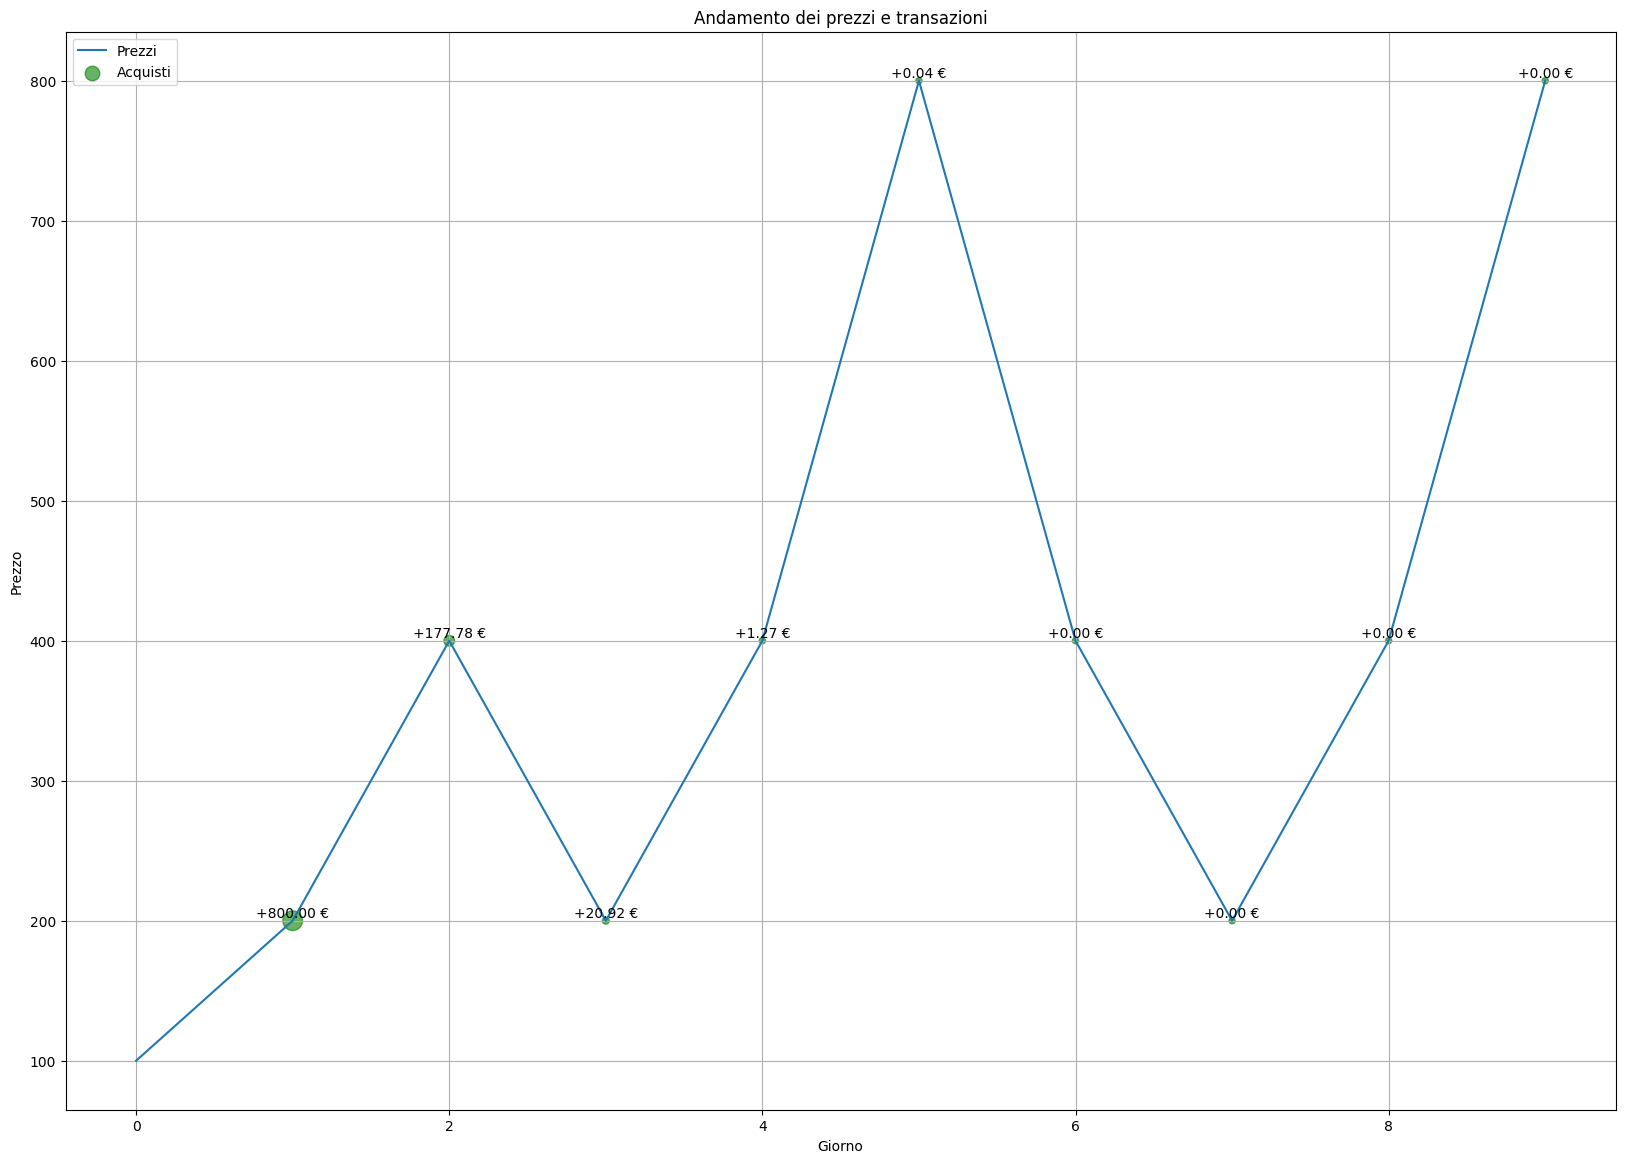

Rendimento totale del portafoglio: 3641.79 €


,Giorno,Prezzo,Tipo,Quantità
0,1,200.0,Acquisto,8.000000e+02
1,2,400.0,Acquisto,1.777778e+02
2,3,200.0,Acquisto,2.091503e+01
3,4,400.0,Acquisto,1.267578e+00
4,5,800.0,Acquisto,3.900239e-02
5,6,400.0,Acquisto,6.046882e-04
6,7,200.0,Acquisto,4.705745e-06
7,8,400.0,Acquisto,1.834598e-08
8,9,800.0,Acquisto,3.579704e-11


In [28]:
# Funzione per generare prezzi casuali secondo una distribuzione di probabilità
def generate_prices(distribution, N):
    prices = [100]  # Prezzo iniziale
    for _ in range(1, N):
        change = np.random.choice(list(distribution.keys()), p=list(distribution.values()))
        new_price = prices[-1] * change
        prices.append(new_price)
    return prices

def max_decimal_places(distribution):
    max_decimals = 0
    for key in distribution.keys():
        # Converte il numero in una stringa e conta i decimali (dopo il punto decimale)
        decimals = str(key)[::-1].find('.')
        if decimals != -1:
            max_decimals = max(max_decimals, decimals)
    return max_decimals

def calculate_probabilities(prices, distribution, tolerance=1e-6):
    # Contiamo quante volte si è verificato ogni cambiamento di prezzo
    counts = {change: 0 for change in distribution.keys()}
    
    for i in range(1, len(prices)):
        # price_change = prices[i] / prices[i-1]
        # Trovare il cambio più vicino in distribuzione
        for change in distribution.keys():
            # if abs(price_change - change) < tolerance:
            if change*prices[i-1] == prices[i]:
                counts[change] += 1
                break
    
    # Calcoliamo le probabilità a posteriori utilizzando l'approccio bayesiano
    updated_distribution = {}
    
    for change, prior_prob in distribution.items():
        observed_count = counts.get(change, 0)
        # Calcolo della probabilità a posteriori per ogni variazione
        updated_prob = prior_prob * (change ** observed_count)
        updated_distribution[change] = updated_prob
    
    # Normalizziamo le probabilità per assicurarci che sommino a 1
    total_prob = sum(updated_distribution.values())
    for change in updated_distribution:
        updated_distribution[change] /= total_prob

    return updated_distribution


# Funzione per calcolare la probabilità che il prezzo salga o scenda
def calculate_probabilities(prices, distribution):
    # Contiamo quante volte si è verificato ogni cambiamento di prezzo
    counts = {change: 0 for change in distribution.keys()}
    
    for i in range(1, len(prices)):
        change = prices[i] / prices[i-1]
        # if change in counts:
        counts[change] += 1
    
    # Calcoliamo le probabilità a posteriori utilizzando l'approccio bayesiano
    # total_observations = len(prices) - 1
    updated_distribution = {}

    for change, prior_prob in distribution.items():
        observed_count = counts.get(change, 0)
        # Calcolo della probabilità a posteriori per ogni variazione
        updated_prob = prior_prob * (change ** observed_count)
        updated_distribution[change] = updated_prob

    # Normalizziamo le probabilità per assicurarci che sommino a 1
    total_prob = sum(updated_distribution.values())
    for change in updated_distribution:
        updated_distribution[change] /= total_prob

    return updated_distribution

# Simulazione della strategia di trading
def simulate_trading(prices, distribution):
    capital = 1000  # Capitale iniziale
    tokens = 0  # Token iniziali
    portfolio_values = [capital]  # Valore del portafoglio nel tempo
    transactions = []

    for i in range(1, len(prices)):
        # Calcoliamo la distribuzione aggiornata per il giorno successivo
        updated_distribution = calculate_probabilities(prices[:i], distribution)
        
        # Calcoliamo il valore atteso per ciascuna variazione di prezzo
        expected_values = {change: change * prob for change, prob in updated_distribution.items()}
        
        # Troviamo la chiave con il valore atteso massimo
        max_expected_value_key = max(expected_values, key=expected_values.get)
        max_expected_value = expected_values[max_expected_value_key]
        
        # Somma di tutti i valori attesi
        total_expected_value = sum(expected_values.values())
        
        # Se il valore atteso massimo è associato a una chiave > 1, acquistiamo
        if max_expected_value_key > 1:
            # Percentuale di liquidità da investire
            investment_ratio = max_expected_value / total_expected_value
            to_invest = capital * investment_ratio
            if to_invest > 0:  # Controllo per evitare acquisti di quantità nulla
                tokens += to_invest / prices[i]
                capital -= to_invest
                transactions.append((i, prices[i], 'Acquisto', to_invest))
        
        # Se il valore atteso massimo è associato a una chiave ≤ 1, vendiamo
        elif max_expected_value_key <= 1:
            # Percentuale di token da vendere
            sell_ratio = max_expected_value / total_expected_value
            to_sell = tokens * sell_ratio
            if to_sell > 0:  # Controllo per evitare vendite di quantità nulla
                capital += to_sell * prices[i]
                tokens -= to_sell
                transactions.append((i, prices[i], 'Vendita', to_sell * prices[i]))
        
        # Aggiorna il valore del portafoglio
        portfolio_values.append(capital + tokens * prices[i])
    
    return portfolio_values, transactions

# Configurazione della distribuzione e del numero di giorni
distribution = {0.5: 0.5, 2: 0.5}
N = 10 # Numero di giorni

# Generazione dei prezzi e simulazione
prices = generate_prices(distribution, N)
portfolio_values, transactions = simulate_trading(prices, distribution)

# Preparazione dei dati per il grafico
transazioni = np.array(transactions, dtype=object)
acquisti = transazioni[transazioni[:, 2] == 'Acquisto']
vendite = transazioni[transazioni[:, 2] == 'Vendita']

# Calcolo delle dimensioni dei punti
max_acquisto = max(acquisti[:, 3]) if len(acquisti) > 0 else 0
max_vendita = max(vendite[:, 3]) if len(vendite) > 0 else 0

def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
    return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita > 0 else min_size

dimensioni_acquisti = [calcola_dimensione(x, max_acquisto) for x in acquisti[:, 3]] if len(acquisti) > 0 else []
dimensioni_vendite = [calcola_dimensione(x, max_vendita) for x in vendite[:, 3]] if len(vendite) > 0 else []

# Creazione del grafico
plt.figure(figsize=(20, 14))
plt.grid()
plt.plot(range(N), prices, label='Prezzi')
if len(acquisti) > 0:
    plt.scatter(acquisti[:, 0], acquisti[:, 1], s=dimensioni_acquisti, color='green', alpha=0.6, label='Acquisti')
    for i, row in enumerate(acquisti):
        plt.text(row[0], row[1], f"+{row[3]:.2f} €", color='black', ha='center', va='bottom')
if len(vendite) > 0:
    plt.scatter(vendite[:, 0], vendite[:, 1], s=dimensioni_vendite, color='red', alpha=0.6, label='Vendite')
    for i, row in enumerate(vendite):
        plt.text(row[0], row[1], f"-{row[3]:.2f} €", color='black', ha='center', va='top')

plt.xlabel('Giorno')
plt.ylabel('Prezzo')
plt.title('Andamento dei prezzi e transazioni')
plt.legend()
plt.show()

# Mostra il rendimento totale del portafoglio
print(f"Rendimento totale del portafoglio: {portfolio_values[-1]:.2f} €")

# Stampa del dataframe delle transazioni
df_transazioni = pd.DataFrame(transactions, columns=['Giorno', 'Prezzo', 'Tipo', 'Quantità'])
df_transazioni

In [39]:
distribution = {0.5: 0.9, 2: 0.1}
prices = [100, 50, 25, 12.5, 25] # generate_prices(distribution, 2)
print(prices)
calculate_probabilities(prices, distribution)

[100, 50, 25, 12.5, 25]


{0.5: 0.36, 2: 0.64}